In [31]:
import cv2
import numpy as np
from camera_spline import CameraSpline
import glob
import os.path as osp
import matplotlib.pyplot as plt
from utils import read_intrinsics

cam_f = "ori_data/ShakeCarpet1/poses_all.txt"
img_dir = "ori_data/ShakeCarpet1/images"
intrinsics_f = "ori_data/ShakeCarpet1/poses_bounds.npy"
rgb_trigger_f = "ori_data/ShakeCarpet1/images/image_stamps_ns.txt"


trig_ts = (np.round(np.loadtxt(rgb_trigger_f)/1e3)).astype(int)
img_fs = sorted(glob.glob(osp.join(img_dir, "*.png")))

img1 = cv2.imread(img_fs[0])
img2 = cv2.imread(img_fs[1])

cams = CameraSpline(cam_f)
# ext1, ext2 = cams.cam_mtrxs[0], cams.cam_mtrxs[1]
Ts, Rs = cams.interpolate(trig_ts[:2]) #(R1, R2), (T1, T2)
intrxs = read_intrinsics(intrinsics_f)
K = intrxs

In [21]:
def rootsift(features):
    # Apply the Hellinger kernel by L1-normalizing the descriptors
    # and then taking the square root
    eps = 1e-7
    features /= (features.sum(axis=1, keepdims=True) + eps)
    features = np.sqrt(features)
    features /= (np.linalg.norm(features, axis=1, keepdims=True) + eps)
    return features

In [22]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

In [23]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
des1 = rootsift(des1)
des2 = rootsift(des2)

In [24]:
matches = bf.knnMatch(des1, des2, k=2)

In [25]:
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

In [26]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
E, mask = cv2.findEssentialMat(src_pts, dst_pts, cameraMatrix=K, method=cv2.RANSAC, prob=0.999999, threshold=0.5)
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
print(len(inlier_matches))

733


In [36]:
# Extract the rotation and translation from the estimated pose
retval, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, cameraMatrix=K)

# Triangulate the points
P1 = K.dot(np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0]]))
P2 = K.dot(np.hstack((R, t)))
points_3d_homogeneous = cv2.triangulatePoints(P1, P2, src_pts, dst_pts)
points_3d = cv2.convertPointsFromHomogeneous(points_3d_homogeneous.T)
print(R)
print(t)
print(t/np.linalg.norm(t))

[[ 0.83741921  0.52599637  0.14851562]
 [-0.53013149  0.84780831 -0.01347872]
 [-0.13300253 -0.06744547  0.9888182 ]]
[[-0.88307673]
 [ 0.44889091]
 [-0.13664713]]
[[-0.88307673]
 [ 0.44889091]
 [-0.13664713]]


In [38]:

R1, R2 = Rs
T1, T2 = Ts
# print(R1.shape, T1.shape)
# print(np.matmul(R2.T, R1))
ext1 = np.concatenate([R1, T1[..., None]], axis = -1)
ext2 = np.concatenate([R2, T2[..., None]], axis = -1)

ext1 = np.concatenate([ext1, np.zeros((1,4))])
ext2 = np.concatenate([ext2, np.zeros((1,4))])
ext1[-1,-1] = 1
ext2[-1,-1] = 1
print(ext1)
u = np.matmul(np.linalg.inv(ext2), ext1)
print(u)
print(u[:3,3]/np.linalg.norm(u[:3,3]))

[[ 0.59460228  0.72138115  0.35504558 -1.50959012]
 [ 0.7293005  -0.66981144  0.13954717 -1.01406999]
 [ 0.33848029  0.17595985 -0.92437504  1.63810691]
 [ 0.          0.          0.          1.        ]]
[[ 0.83730021  0.52562801  0.15047776 -0.7977401 ]
 [-0.52978378  0.84801228 -0.01429403  0.40614727]
 [-0.13512033 -0.06775228  0.98851005 -0.11846041]
 [ 0.          0.          0.          1.        ]]
[-0.88345005  0.44978411 -0.13118791]


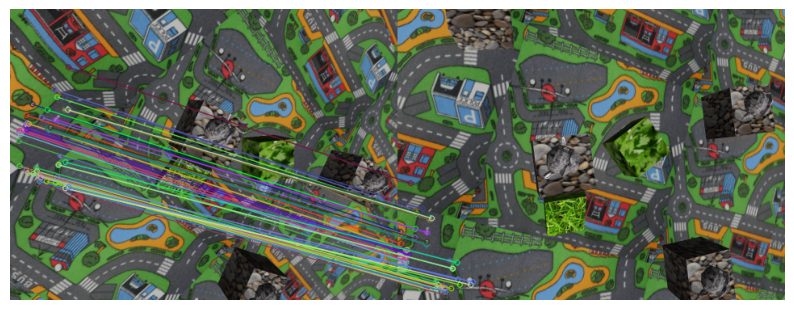

array([[[ 0.87013334,  0.4928164 , -3.2004108 ]],

       [[ 0.9762108 ,  0.21682365, -3.4983766 ]],

       [[ 0.9995588 ,  0.02970167, -3.5292916 ]],

       ...,

       [[ 0.93349963, -0.35857826, -3.1900687 ]],

       [[ 0.93349963, -0.35857826, -3.1900687 ]],

       [[ 0.944181  , -0.32942706, -3.235693  ]]], dtype=float32)

In [82]:
# Visualize correspondences
img3 = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()


In [83]:

# Compute the epipolar lines
lines2 = cv2.computeCorrespondEpilines(dst_pts.reshape(-1, 1, 2), 2, F)
lines2 = lines2.reshape(-1, 3)

# Plot the epipolar lines on the first image
for r, pt in zip(lines2, src_pts):
    color = tuple(np.random.randint(0, 255, 3).tolist())
    x0, y0 = map(int, [0, -r[2] / r[1]])
    x1, y1 = map(int, [img1.shape[1], -(r[2] + r[0] * img1.shape[1]) / r[1]])
    img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)

# Display the epipolar lines on the first image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()


NameError: name 'F' is not defined